In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths, coordinates_bounds, plot_feature_importances

In [5]:
def load_posts(input_path):
    df = pd.read_parquet(input_path)
    return df

In [6]:
if __name__ == "__main__":
    city = "manizales"
    property_type = "casas"
    post_type = "venta"
    
    #city, property_type, post_type = check_args()
    base_path = os.environ.get('REPO')

    raw_path, clean_path = gen_paths(city, property_type, post_type)
    
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
MSG = """
Hay {} publicaciones de {} en total
"""

posts = load_posts(clean_path)
print(MSG.format(posts.shape[0], post_type))
posts.head()


Hay 1992 publicaciones de venta en total



,surface,rooms,baths,garages,price,latitude,description,longitude,location,url,admon,estrato,antiguedad,fid,city,property_type,post_type,price_m2
1,180.0,4.0,1.0,1.0,250.0,5.061220,"Casa ubicada en el barrio La Sultana, consta d...",-75.472801,Manizales LA SULTANA,https://www.fincaraiz.com.co/casa-en-venta/man...,0.0,3.0,16 a 30,5151631,manizales,casas,venta,1.388889
2,130.0,4.0,2.0,0.0,225.0,5.047913,"Area de 130 mtrs, excelente ubicacion, casa co...",-75.501884,Manizales MALHABAR,https://www.fincaraiz.com.co/casa-en-venta/man...,0.0,3.0,16 a 30,4715541,manizales,casas,venta,1.730769
3,407.0,9.0,6.0,5.0,1200.0,5.069806,"Excelente inversion, venta de propiedad horizo...",-75.530762,Manizales La francia,https://www.fincaraiz.com.co/casa-en-venta/man...,0.0,6.0,desconocido,3333614,manizales,casas,venta,2.948403
4,118.0,3.0,3.0,1.0,450.0,5.027654,Vista Inmobiliaria ofrece en venta linda casa ...,-75.481209,Manizales La Florida,https://www.fincaraiz.com.co/casa-en-venta/man...,285000.0,4.0,desconocido,5392228,manizales,casas,venta,3.813559
5,115.0,3.0,3.0,2.0,370.0,5.038804,Venta casa en conjunto cerrado en el sector de...,-75.487785,Manizales La Florida,https://www.fincaraiz.com.co/casa-en-venta/man...,220000.0,4.0,1 a 8,5613118,manizales,casas,venta,3.217391


## Es necesario cambiar la representación de algunas de las columnas


In [8]:
## La antiguedad tiene 5 posibles valores pero se representa con un string, la idea es usar un entero en cambio

antiguedades = posts["antiguedad"].value_counts().index
new_antiguedades = {}
for i in range(len(antiguedades)):
    new_antiguedades[antiguedades[i]] = i
new_antiguedades

{'desconocido': 0, '16 a 30': 1, '9 a 15': 2, '1 a 8': 3, 'Más de 30': 4}

In [9]:
posts.loc[:, "antiguedad"] = posts["antiguedad"].apply(lambda e: new_antiguedades[e])

In [10]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = [
    'surface', 'rooms', 
    'baths', 'garages', 'latitude', 
    'longitude', 'admon', 
    'estrato','antiguedad'
]

LABEL = "price"

X = posts[FEATURES].values
y = posts[LABEL].values

## Selección de features univariada

In [11]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

(1992, 5)

In [12]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

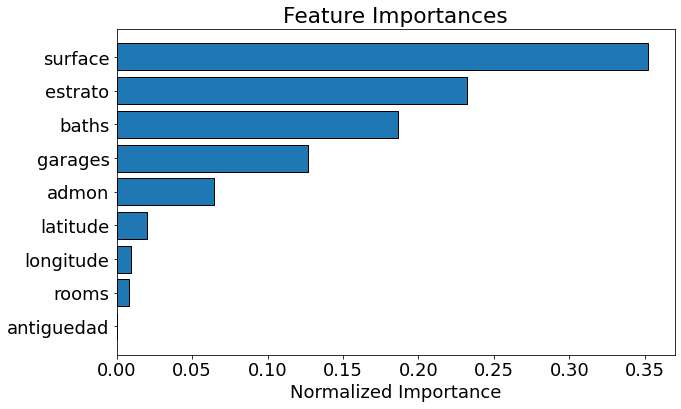

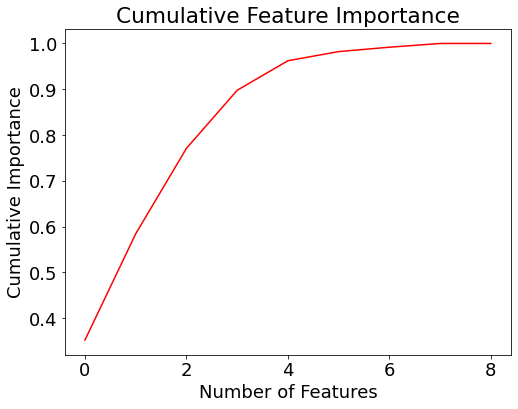

5 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,1421.385950,surface,0.352070,0.352070
1,7,936.823537,estrato,0.232047,0.584117
2,2,753.720807,baths,0.186693,0.770810
3,3,512.311555,garages,0.126897,0.897707
4,6,260.630616,admon,0.064557,0.962264
5,4,80.506122,latitude,0.019941,0.982205
6,5,38.767677,longitude,0.009603,0.991808
7,1,33.062457,rooms,0.008189,0.999997
8,8,0.012440,antiguedad,0.000003,1.000000


In [13]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [15]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.5903186306881789

In [16]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [17]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

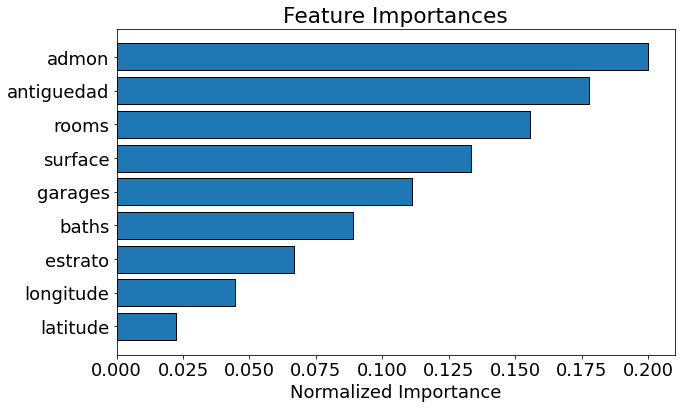

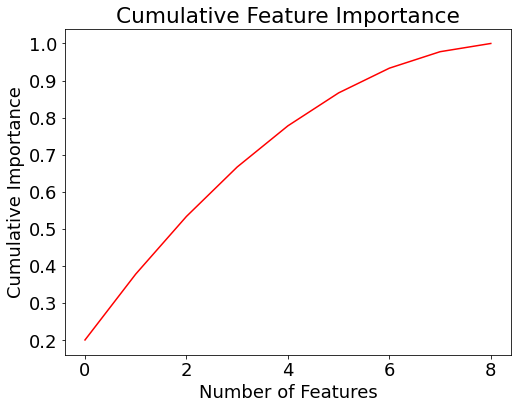

7 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,6,9,admon,0.200000,0.200000
1,8,8,antiguedad,0.177778,0.377778
2,1,7,rooms,0.155556,0.533333
3,0,6,surface,0.133333,0.666667
4,3,5,garages,0.111111,0.777778
5,2,4,baths,0.088889,0.866667
6,7,3,estrato,0.066667,0.933333
7,5,2,longitude,0.044444,0.977778
8,4,1,latitude,0.022222,1.000000


In [18]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [19]:
from sklearn.ensemble import ExtraTreesRegressor

In [20]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [21]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

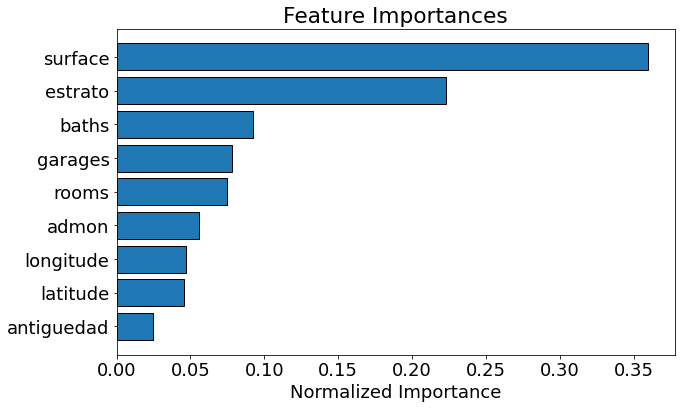

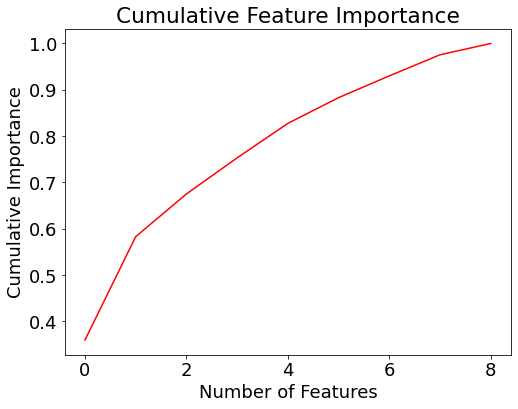

7 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,0.359678,surface,0.359678,0.359678
1,7,0.223125,estrato,0.223125,0.582803
2,2,0.092207,baths,0.092207,0.675010
3,3,0.078009,garages,0.078009,0.753019
4,1,0.074454,rooms,0.074454,0.827474
5,6,0.055547,admon,0.055547,0.883021
6,5,0.047002,longitude,0.047002,0.930023
7,4,0.045545,latitude,0.045545,0.975569
8,8,0.024431,antiguedad,0.024431,1.000000


In [22]:
plot_feature_importances(feature_importances)